**Table of contents**<a id='toc0_'></a>    
- [Import Statements](#toc1_1_)    
- [Turning EDA into action](#toc2_)    
  - [*Considerations for categorical data*](#toc2_1_)    
  - [*Creating new features*](#toc2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=5
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_'></a>[Import Statements](#toc0_)

In [43]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## <a id='toc2_'></a>[Turning EDA into action](#toc0_)

### <a id='toc2_1_'></a>[*Considerations for categorical data*](#toc0_)

EDA is performed for a variety of reasons, like detecting patterns and relationships in data, generating questions or hypotheses, or to prepare data for machine learning models. 

There's one requirement our data must satisfy regardless of our plans after performing EDA - it must be representative of the population we wish to study. For example, if we collect data with the aim of analyzing the relationship between education level and income in the USA, then we would need to collect this data from adults residing in the USA, and can't rely on data from residents of France. 

With categorical data, one of the most important considerations is about the representation of classes, which is another term for labels. For example, say we collect data on people's attitudes to marriage. As part of our data collection we find out their marital status, with the classes including single, married, and divorced. When we perform EDA we realize only 50 people were married, while 700 were divorced and the remaining 250 were single. Do we think that this sample accurately represents the general public's opinion about marriage? Are divorced people more likely to have a negative view towards marriage? This is an example of class imbalance, where one class occurs more frequently than others. This can bias results, particularly if this class does not occur more frequently in the population. Relative class frequencies are crucial for effective EDA.

In [114]:
salaries = pd.read_csv("./datasets/ds_salaries_clean.csv")

In [116]:
salaries.head()

,Working_Year,Designation,Experience,Employment_Status,Employee_Location,Company_Size,Remote_Working_Ratio,Salary_USD
0,2020,Data Scientist,Mid,FT,DE,L,0,76227.0
1,2020,Machine Learning Scientist,Senior,FT,JP,S,0,248257.0
2,2020,Big Data Engineer,Senior,FT,GB,M,50,104100.0
3,2020,Product Data Analyst,Mid,FT,HN,S,0,19097.0
4,2020,Machine Learning Engineer,Senior,FT,US,L,50,143225.0


To view the Relative class frequencies we can use, `.value_counts(normalize=True)`.

In [136]:
print(salaries.Experience.value_counts(normalize=True))

Experience
Senior       0.461285
Mid          0.350906
Entry        0.144975
Executive    0.042834
Name: proportion, dtype: float64


Another method for looking at class frequency is cross-tabulation, which enables us to examine the frequency of combinations of classes. For example `pd.crosstab()` can be used to see the frequency of combinations of the "Company_Size" and "Experience" classes. By default the crosstab method returns the absolute frequencies, but we can use the normalize parameter to view the relative frequencies. We can also use other aggregation functions with the aggfunc parameter.

In [139]:
print(pd.crosstab(salaries["Company_Size"], salaries["Experience"]))

Experience    Entry  Executive  Mid  Senior
Company_Size                               
L                29         11   86      72
M                30         12   98     186
S                29          3   29      22


In [137]:
## Same as,

# salaries.groupby(["Company_Size", "Experience"]).agg("size").unstack()
# salaries.pivot_table(index="Company_Size", columns="Experience", aggfunc="size")

### <a id='toc2_2_'></a>[*Creating new features*](#toc0_)

Sometimes the format of our data can limit our ability to detect relationships or inhibit the potential performance of machine learning models. One method to overcome these issues is to generate new features from our data!

In [146]:
planes = planes.drop(columns="airline_price_st_dev")

<Axes: >

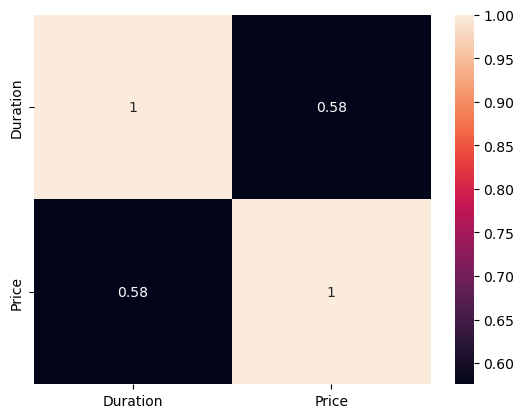

In [148]:
sns.heatmap(planes.corr(numeric_only=True), annot=True)

Checking the correlation with a heatmap reveals that there is a moderate relationship between the flight duration and the price. But it seems that our dataframe has only two numeric columns. So we inspect the datframe to see if we can generate some more numeric columns.

In [ ]:
planes.dtypes

Airline               object
Date_of_Journey       object
Source                object
Destination           object
Route                 object
Dep_Time              object
Arrival_Time          object
Duration             float64
Total_Stops           object
Price                float64
Duration_Category     object
dtype: object

In [151]:
# The Duration and the Price of the flight is most likely related to the number of stops. But it is currently in string format.
planes["Total_Stops"].value_counts()

Total_Stops
1 stop      4411
non-stop    2784
2 stops     1207
3 stops       35
4 stops        1
Name: count, dtype: int64

In [ ]:
# Let's convert it to a numeric column
